Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Forecasting Pipeline
---

In this notebook we create a pipeline to forecast sales with the models we trained in the last step. The forecasting pipeline we'll set up is similar to the training pipeline in the last step so we'll keep the documentation light. For more details on the steps and functions refer to the last notebook.

### Prerequisites
At this point, you should have already:

1. Created your AML Workspace using the [00_Setup_AML_Workspace notebook](../00_Setup_AML_Workspace.ipynb)
2. Run [01_Data_Preparation.ipynb](01_Data_Preparation.ipynb) to setup your compute and create the dataset
3. Run [02_Training_Pipeline.ipynb](02_Training_Pipeline.ipynb) to train the models

## 1.0 Connect to workspace and datastore

In [1]:
from azureml.core import Workspace
from azureml.core import Datastore

ws = Workspace.from_config()

# set up datastores
dstore = ws.get_default_datastore()

print('Workspace Name: ' + ws.name, 
      'Azure Region: ' + ws.location, 
      'Subscription Id: ' + ws.subscription_id, 
      'Resource Group: ' + ws.resource_group, sep='\n')

Workspace Name: erwrightDevTest
Azure Region: westus2
Subscription Id: 381b38e9-9840-4719-a5a0-61d9585e1e91
Resource Group: erwright-automl


## 2.0 Create an experiment

In [3]:
from azureml.core import Experiment

experiment = Experiment(ws, 'forecasting_pipeline')

## 3.0 Get the dataset

In [3]:
from azureml.core.dataset import Dataset

small_dataset = Dataset.get_by_name(ws, name='oj_data_small_test')
small_dataset_input = small_dataset.as_named_input('forecast_10_models')

## 4.0 Create ParallelRunStep for the forecasting pipeline
As we did with the training pipeline, we'll create a ParallelRunStep to parallelize our forecasting process. You'll notice this code is essentially the same as the last step except that we'll be parallelizing **forecast.py** rather than train.py.

### 4.1 Configure environment for ParallelRunStep

In [4]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

forecast_env = Environment(name="many_models_environment")
forecast_conda_deps = CondaDependencies.create(pip_packages=['sklearn', 'joblib'])
forecast_env.python.conda_dependencies = forecast_conda_deps

### 4.2 Choose a compute target

In [5]:
from azureml.core.compute import AmlCompute
compute = AmlCompute(ws, "cpucluster")

### 4.3 Set up ParallelRunConfig

In [28]:
from azureml.contrib.pipeline.steps import ParallelRunConfig 

process_count_per_node = 6
node_count = 1
timeout = 180

tags = {}
tags['node_count'] = node_count
tags['process_count_per_node'] = process_count_per_node
tags['timeout'] = timeout

parallel_run_config = ParallelRunConfig(
    source_directory='./scripts',
    entry_script='forecast.py',
    mini_batch_size='1',
    run_invocation_timeout=timeout, 
    error_threshold=10,
    output_action='append_row', 
    environment=forecast_env, 
    process_count_per_node=process_count_per_node, 
    compute_target=compute, 
    node_count=node_count
)

### 4.4 Set up ParallelRunStep

In [29]:
from azureml.pipeline.core import PipelineData
from azureml.contrib.pipeline.steps import ParallelRunStep 

output_dir = PipelineData(name='forecasting_output', datastore=dstore)

parallel_run_step = ParallelRunStep(
    name="many-models-forecasting",
    parallel_run_config=parallel_run_config,
    inputs=[small_dataset_input],
    output=output_dir,
    allow_reuse=False,
    arguments=['--target_column', 'Quantity',
               '--timestamp_column', 'WeekStarting',
               '--timeseries_id_columns', 'Store', 'Brand',
               '--model_type', 'lr']
)

## 5.0 Create step to copy predictions

The forecasting pipeline includes a second step that copies the predictions from *parallel_run_step.txt* to a CSV file in a separate container. While this step is simple, it demonstates how a step can be added to the pipeline to upload the predictions to a separate datastore or make additional transformations to the output.

### 5.1 Create a data reference
First, we create a datastore named **predictions** to hold the outputs of the pipeline and get a reference to it:

In [30]:
from azureml.data.data_reference import DataReference

output_dstore = Datastore.register_azure_blob_container(
    workspace=ws, 
    datastore_name="predictions",
    container_name="predictions",
    account_name=dstore.account_name,
    account_key=dstore.account_key,
    create_if_not_exists=True
)

output_dref = DataReference(output_dstore)

### 5.2 Create PythonScriptStep
Next, we define the [PythonScriptStep](https://docs.microsoft.com/en-us/python/api/azureml-pipeline-steps/azureml.pipeline.steps.python_script_step.pythonscriptstep?view=azure-ml-py) and give it our newly create datastore as well as the location of the *parallel_run_step.txt*:

In [33]:
from azureml.pipeline.steps import PythonScriptStep

upload_predictions_step = PythonScriptStep(
    name="copy_predictions",
    script_name="copy_predictions.py",
    compute_target=compute,
    source_directory='./scripts',
    inputs=[output_dref, output_dir],
    allow_reuse=False,
    arguments=['--parallel_run_step_output', output_dir,
               '--output_dir', output_dref,
               '--target_column', 'Quantity',
               '--timestamp_column', 'WeekStarting',
               '--timeseries_id_columns', 'Store', 'Brand',]
)

## 6.0 Run the pipeline

In [34]:
from azureml.pipeline.core import Pipeline

pipeline = Pipeline(workspace=ws, steps=[parallel_run_step, upload_predictions_step])
run = experiment.submit(pipeline, tags=tags)

Created step many-models-forecasting [314478ce][f34a2ff9-58a9-4dea-a39e-71d0fc640627], (This step will run and generate new outputs)
Created step copy_predictions [64f4428f][5554ab44-91e9-41ac-ae52-e3e6a77e395e], (This step will run and generate new outputs)
Using data reference forecast_10_models_0 for StepId [61576db2][f136fe6f-d56f-4050-b0b0-a05ff5ee10c6], (Consumers of this data are eligible to reuse prior runs.)Using data reference predictions for StepId [477d36dd][a8543e5d-0ef0-419c-928f-67f955f645ae], (Consumers of this data are eligible to reuse prior runs.)

Submitted PipelineRun 029f8224-f8e1-4c2c-8e13-62f614bae1da


WARNING - Converting non-string tag to string: (node_count: 1)
WARNING - Converting non-string tag to string: (process_count_per_node: 6)
WARNING - Converting non-string tag to string: (timeout: 180)


Link to Azure Machine Learning Portal: https://ml.azure.com/experiments/forecasting_pipeline/runs/029f8224-f8e1-4c2c-8e13-62f614bae1da?wsid=/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/erwright-automl/workspaces/erwrightDevTest


In [7]:
from azureml.pipeline.core import PipelineRun
run = PipelineRun(experiment, '029f8224-f8e1-4c2c-8e13-62f614bae1da')

## 7.0 View the results of the forecasting pipeline
To see our forecasts, we download the *parallel_run_step.txt*, read the results into a dataframe, and visualize the predictions. Note that we could also download the results from the predictions container we created above.

### 7.1 Download parallel_run_step.txt locally
You need to wait until run that was submitted to Azure Machine Learning Compute Cluster is complete. You can monitor the run status in https://ml.azure.com

In [8]:
import os
from pathlib import Path

def download_predictions(run, target_dir=None):
    stitch_run = run.find_step_run("many-models-forecasting")[0]
    port_data = stitch_run.get_output_data('forecasting_output')
    print(port_data)
    port_data.download(target_dir, show_progress=True, overwrite=True)
    step_hash = os.listdir(os.path.join(target_dir, 'azureml'))[0]
    latest = sorted(Path(os.path.join(target_dir, 'azureml')).iterdir(), key=os.path.getmtime)
    return  os.path.join(latest[-1], 'forecasting_output')

file_path = download_predictions(run, 'output')
file_path

$AZUREML_DATAREFERENCE_forecasting_output
Downloaded azureml/bfb1fb24-6642-422e-8792-62a02043ec34/forecasting_output/parallel_run_step.txt, 1 files out of an estimated total of 1


'output\\azureml\\bfb1fb24-6642-422e-8792-62a02043ec34\\forecasting_output'

### 7.2 Convert the file to a dataframe

In [9]:
import pandas as pd

df = pd.read_csv(file_path + '/parallel_run_step.txt', sep=" ", header=None)
df.columns = ['WeekStarting', 'Predictions', 'Quantity', 'Store', 'Brand']
df['WeekStarting'] = pd.to_datetime(df['WeekStarting'])
# df['WeekStarting'] = [d.date() for d in pd.to_datetime(df['WeekStarting'])]
df.head()

,WeekStarting,Predictions,Quantity,Store,Brand
0,1992-05-21,14196.072104,15843,1001,tropicana
1,1992-05-28,13875.318715,9244,1001,tropicana
2,1992-06-04,14624.301488,19474,1001,tropicana
3,1992-06-11,14770.972550,14695,1001,tropicana
4,1992-06-18,14461.237307,11428,1001,tropicana


### 7.3 Visualize the predictions
First, we look at the distribution of predicted quantities by brand:

Text(0.5, 1.0, 'Predictions by Brand')

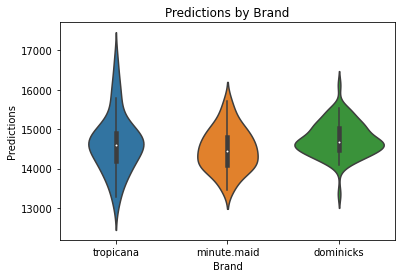

In [10]:
import seaborn as sns
fig = sns.violinplot(x=df['Brand'], y=df['Predictions'], data=df)
fig.set_title('Predictions by Brand')

Then we look at those predictions over time:

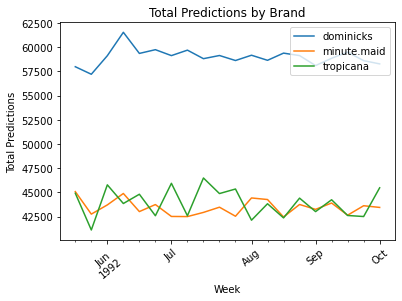

In [11]:
import matplotlib.pyplot as plt

week = df.groupby(['WeekStarting', 'Brand'])
week = week['Predictions'].sum()
week = pd.DataFrame(week.unstack(level=1))

week.plot()
plt.title('Total Predictions by Brand')
plt.xticks(rotation=40)
plt.legend(loc='upper right')
plt.xlabel('Week')
plt.ylabel('Total Predictions')
plt.show()

From there, we can trim the results to look at individual brands:

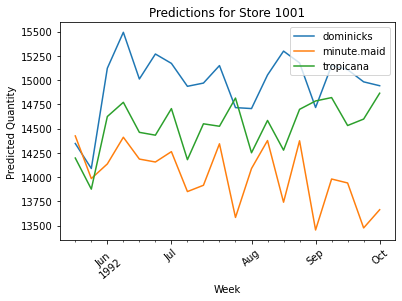

In [12]:
store = 1001
df_1001 = df[df['Store'] == store]

brands = df_1001.groupby(['WeekStarting','Brand'])
brands= brands['Predictions'].sum()
brands= pd.DataFrame(brands.unstack(level=1))

brands.plot()
plt.legend(loc='upper right', labels=brands.columns.values)
plt.xticks(rotation=40)
plt.title('Predictions for Store 1001')
plt.xlabel('Week')
plt.ylabel('Predicted Quantity')
plt.show()

Since we produced forecasts on a test set, we can also examine forecast errors at each date. 

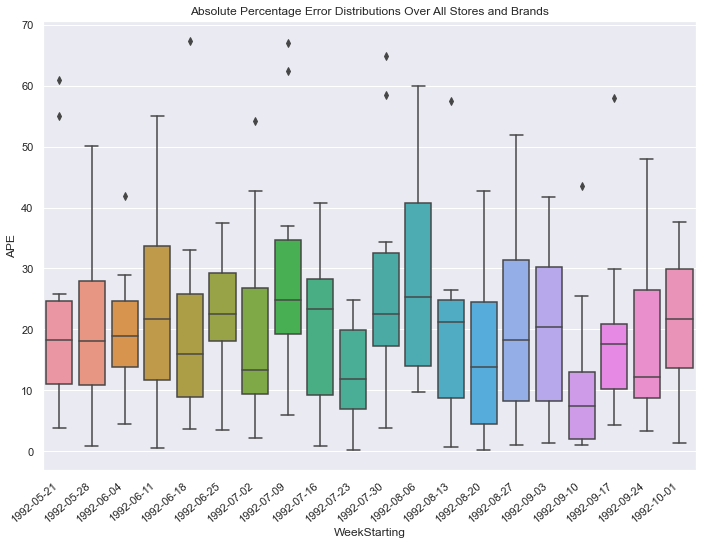

In [28]:
import numpy as np

# Compute the absolute percentage error for each forecast at each date
# Warning: percentage errors are not defined if the actuals contain zero values
df['APE'] = 100*np.abs((df['Quantity'].values - df['Predictions'].values) / df['Quantity'].values)

with sns.axes_style():
    fig = sns.boxplot(x='WeekStarting', y='APE', data=df)
    x_dates = df['WeekStarting'].dt.strftime('%Y-%m-%d')
    fig.set_xticklabels(x_dates, rotation=40, horizontalalignment='right')
    fig.set_title('Absolute Percentage Error Distributions Over All Stores and Brands')
    plt.show()

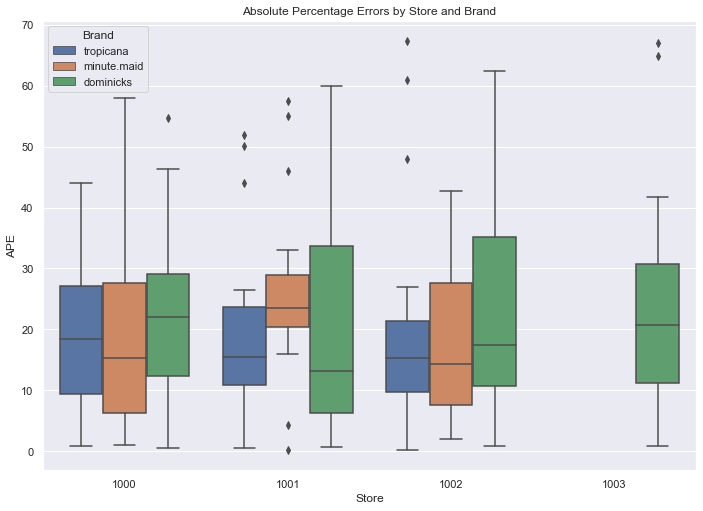

In [27]:
#fig, ax = plt.subplots(figsize = (10,6))
with sns.axes_style():
    fig = sns.boxplot(x='Store', y='APE', hue='Brand', data=df)
    fig.set_title('Absolute Percentage Errors by Store and Brand')
    plt.show()

## 8.0 Publish and schedule the pipeline (Optional)


### 8.1 Publish the pipeline
Once you have a pipeline you're happy with, you can publish a pipeline so you can call it programatically later on. See this [tutorial](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-create-your-first-pipeline#publish-a-pipeline) for additional information on publishing and calling pipelines.

In [ ]:
# published_pipeline = pipeline.publish(name = 'forecast_many_models',
#                                      description = 'forecast many models',
#                                      version = '1',
#                                      continue_on_step_failure = False)

### 8.2 Schedule the pipeline
You can also [schedule the pipeline](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-schedule-pipelines) to run on a time-based or change-based schedule. This could be used to automatically retrain models every month or based on another trigger such as data drift.

In [ ]:
# from azureml.pipeline.core import Schedule, ScheduleRecurrence
    
# training_pipeline_id = published_pipeline.id

# recurrence = ScheduleRecurrence(frequency="Week", interval=1, start_time="2020-01-01T09:00:00")
# recurring_schedule = Schedule.create(ws, name="forecasting_pipeline_recurring_schedule", 
#                             description="Schedule Forecasting Pipeline to run on the first day of every week",
#                             pipeline_id=training_pipeline_id, 
#                             experiment_name=experiment.name, 
#                             recurrence=recurrence)